In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.n_jobs = 6

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [3]:
adata = sc.read_10x_mtx("../data/Ileum/", cache=True)
adata

... reading from cache file cache/..-data-Ileum-matrix.h5ad


AnnData object with n_obs × n_vars = 39671 × 33660
    var: 'gene_ids'

In [4]:
obs = pd.read_table("../data/Ileum/Effi_tsne_final.txt", header=[0, 1])
obs.columns = [i[0] for i in obs.columns]
obs.index = obs.NAME
adata = adata[obs.NAME, :]
adata.obs = obs
adata.obsm['X_orig'] = adata.obs[['X', 'Y']]
adata.obs

,NAME,X,Y,Primary Lineages,kmeans
NAME,,,,,
122_AAACCTGGTTCCCGAG,122_AAACCTGGTTCCCGAG,-17.523981,25.760201,IgA plasma cells,5
122_AAAGATGTCAGCTCTC,122_AAAGATGTCAGCTCTC,-4.299636,-1.107461,Tregs,2
122_AAAGCAACAAGAAGAG,122_AAAGCAACAAGAAGAG,18.438143,-1.855235,Mast cells,17
122_AAATGCCTCACCCGAG,122_AAATGCCTCACCCGAG,8.266746,4.860057,TRM,3
122_AACCATGCATCACCCT,122_AACCATGCATCACCCT,1.359606,36.710104,IgA plasma cells,10
...,...,...,...,...,...
209_TTTGTCAGTCTCTTAT,209_TTTGTCAGTCTCTTAT,11.309222,21.416638,TRM,1
209_TTTGTCAGTGTGGTTT,209_TTTGTCAGTGTGGTTT,23.971407,1.429820,Group3 ILC,13
209_TTTGTCATCAGTTAGC,209_TTTGTCATCAGTTAGC,8.514284,0.595697,TRM,3


## QC

The dataset is already filtered, so no need to do additional QC.
Nevertheless, we show the figures.

normalizing counts per cell
    finished (0:00:00)


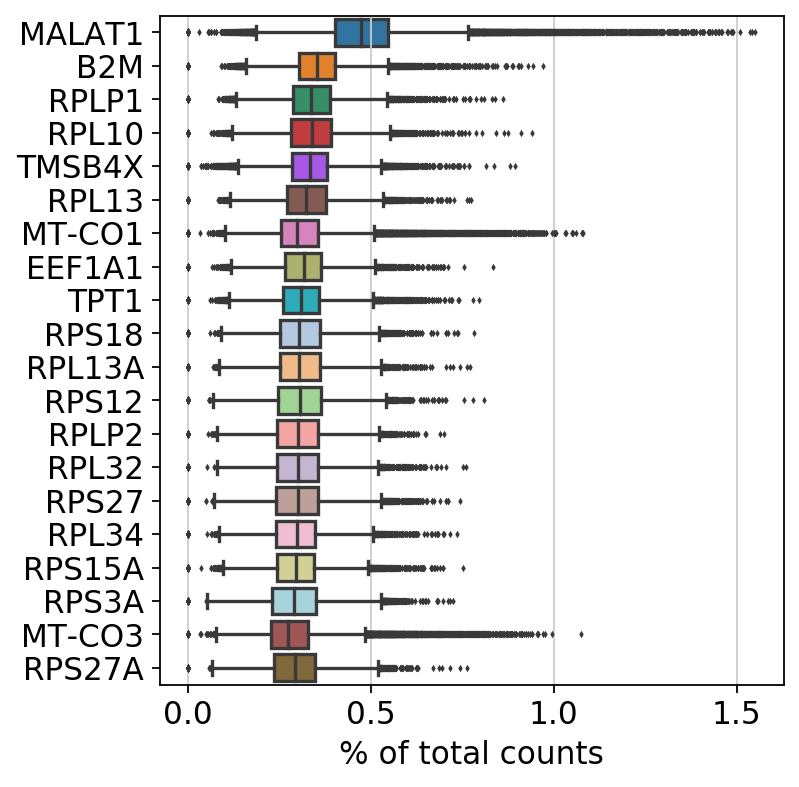

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

... storing 'Primary Lineages' as categorical


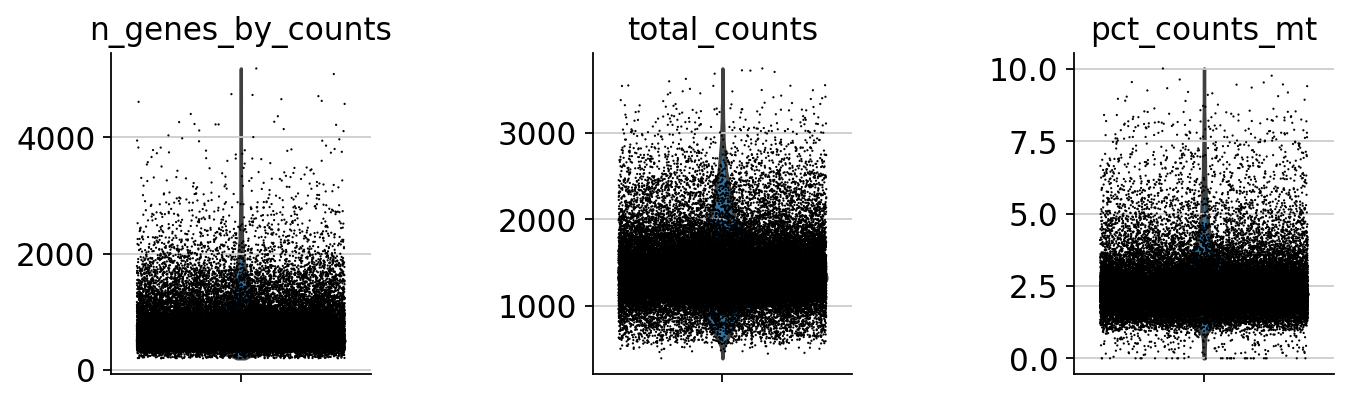

In [6]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

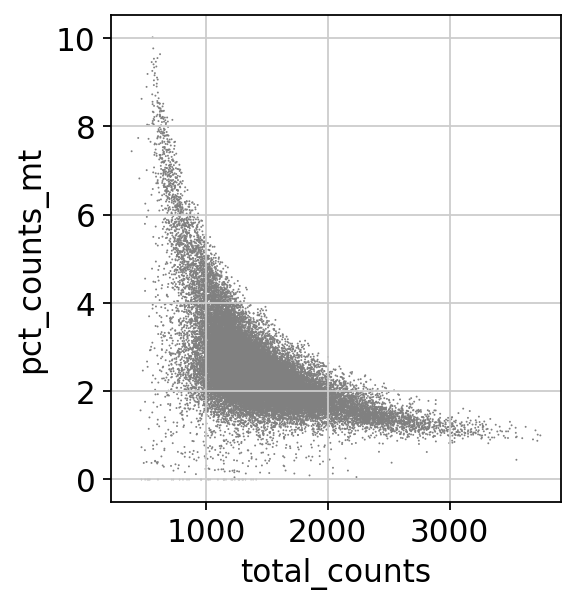

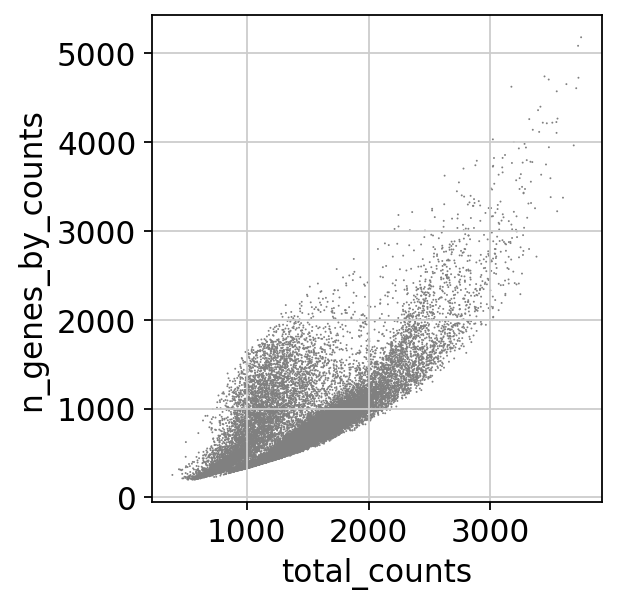

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
adata.raw = adata

In [9]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 11319 genes that are detected in less than 3 cells


In [10]:
sc.pp.normalize_total(adata, target_sum=1e3)

normalizing counts per cell
    finished (0:00:00)


In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [15]:
from pyuoi.decomposition.CUR import CUR
cur = CUR(max_k=2000, random_state=0)
adata.obsm['X_cur'] = cur.fit_transform(adata.X)

In [16]:
sc.pp.neighbors(adata, use_rep="X_cur")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:16:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


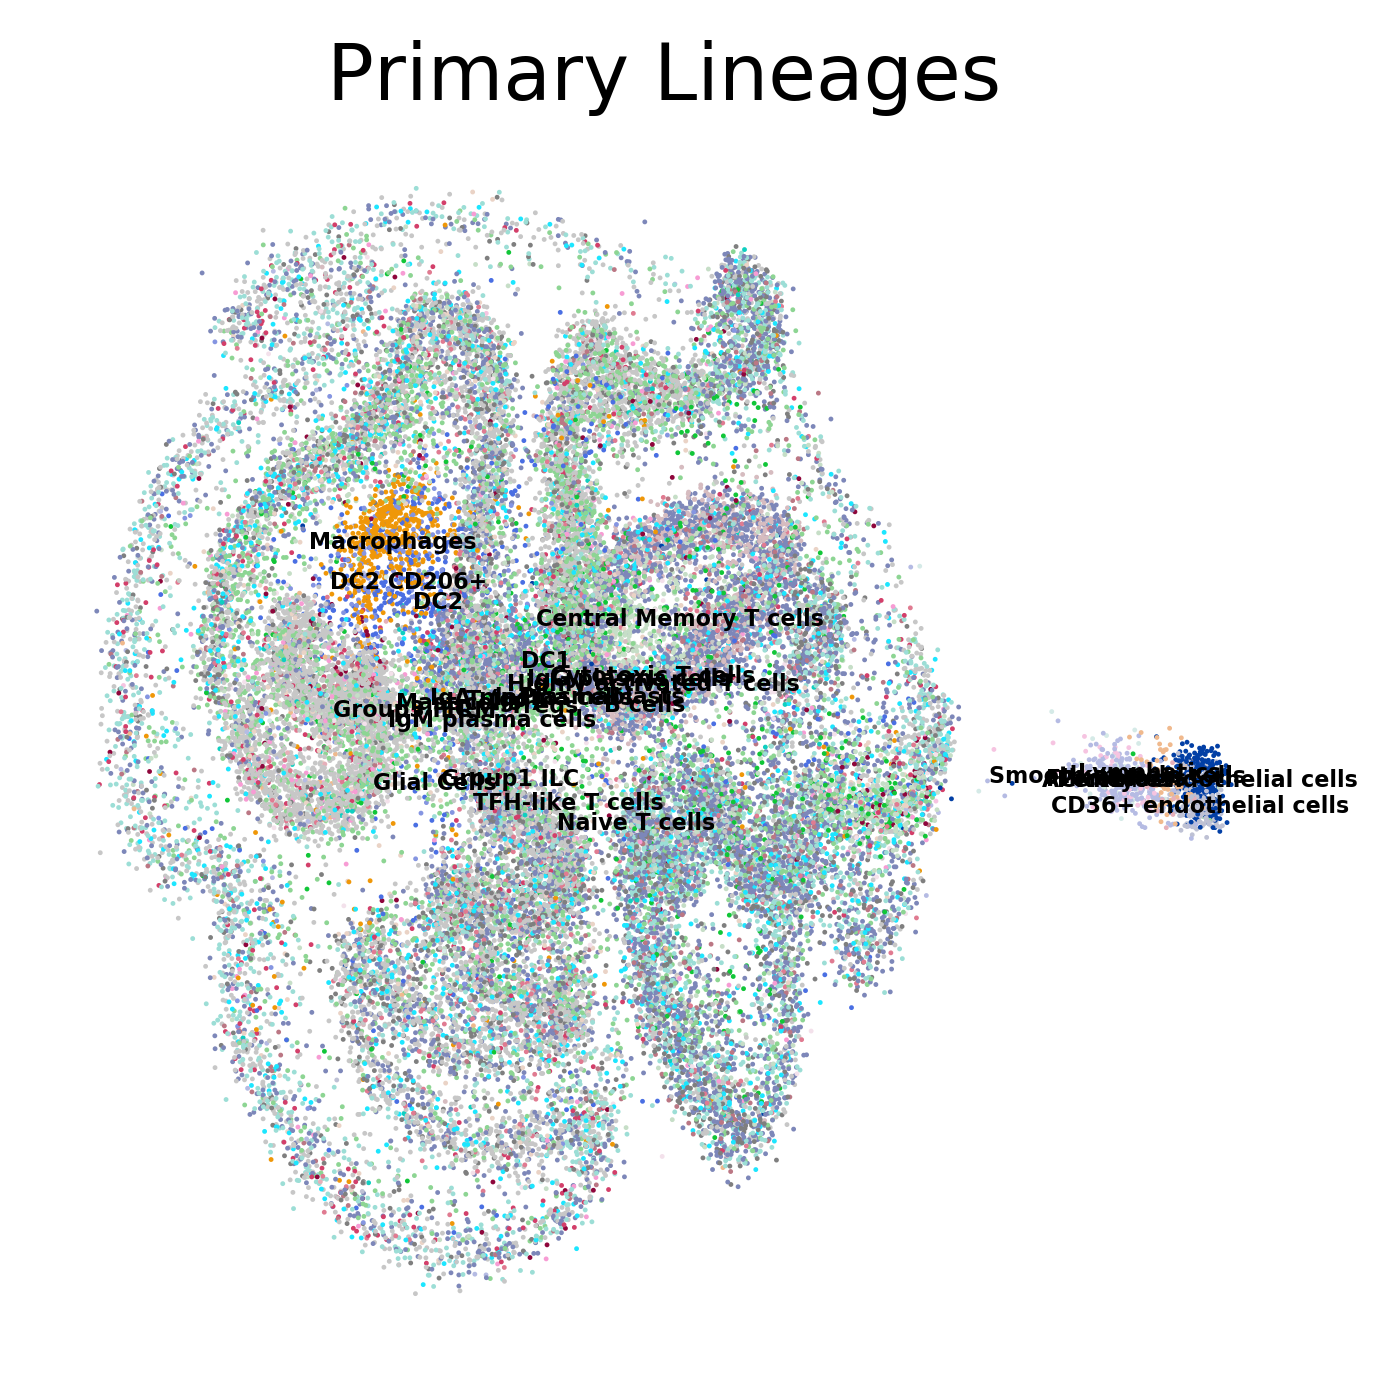

In [17]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.umap(adata, color="Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

## Original embedding (from the website)

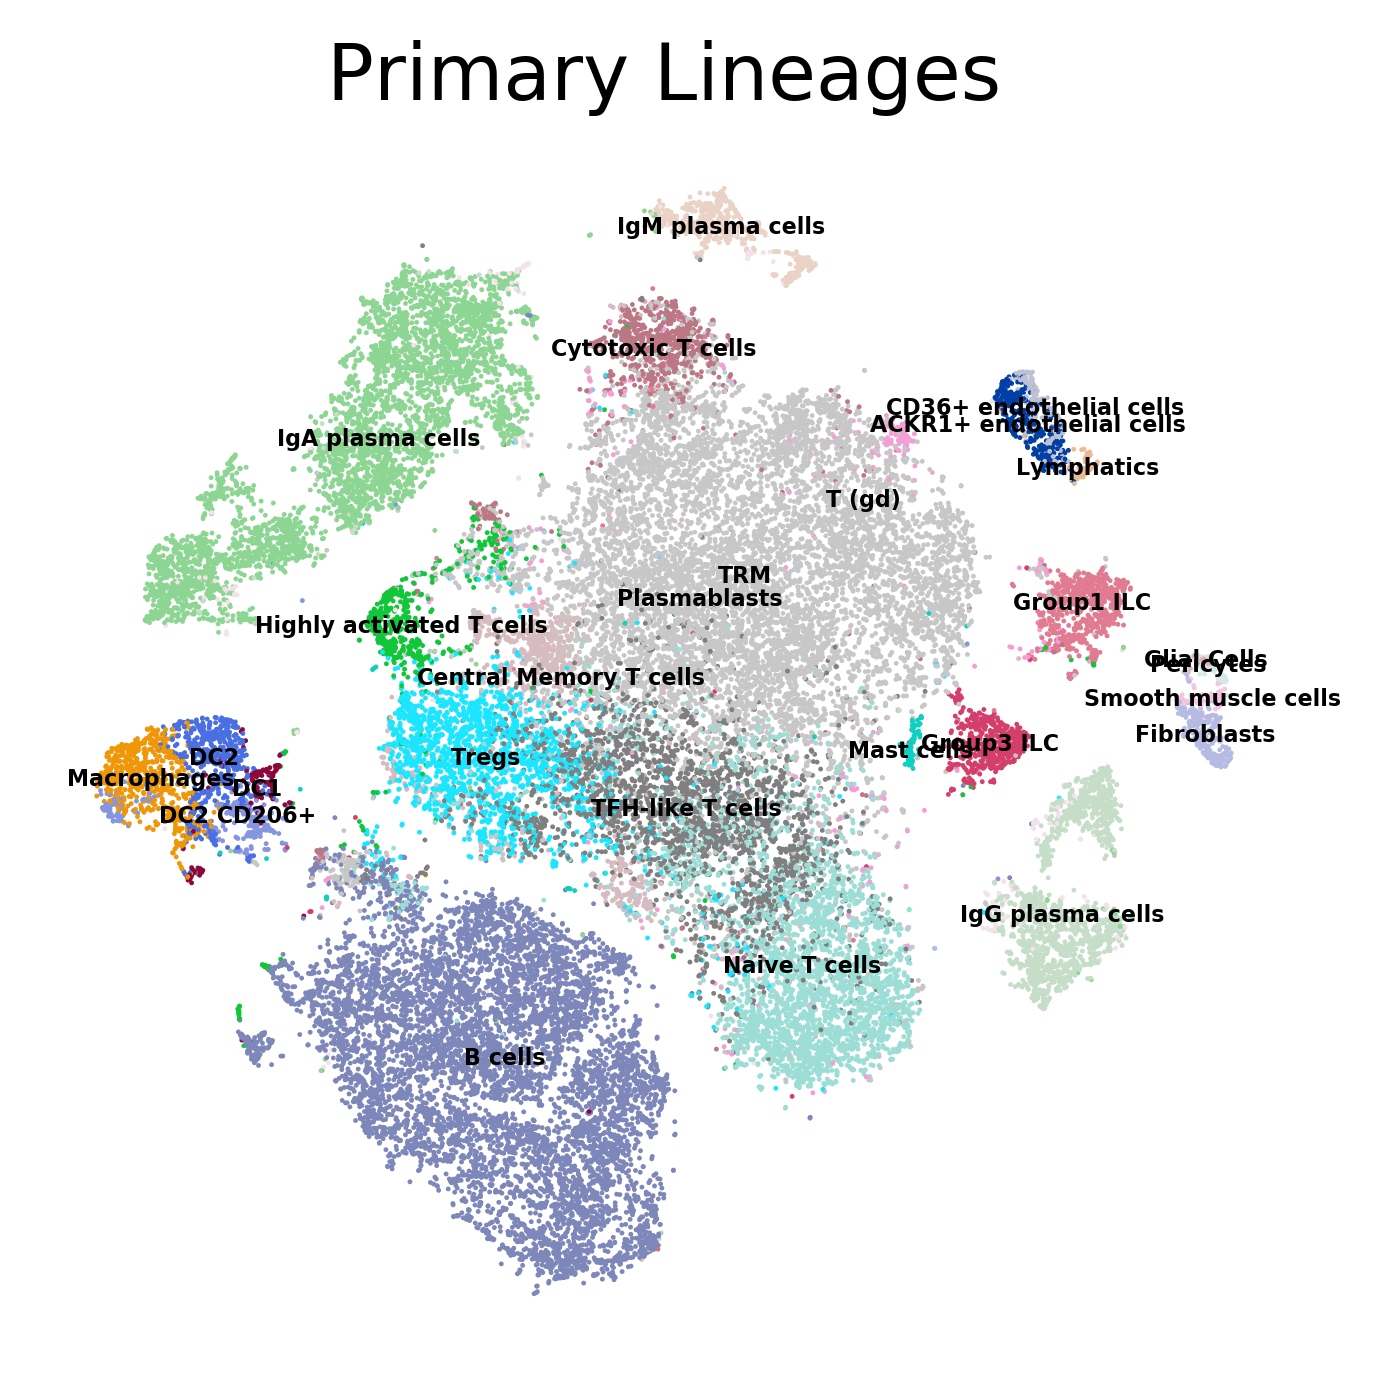

In [19]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.embedding(adata, 'X_orig', color="Primary Lineages", frameon=False, ncols=2, legend_loc="on data", legend_fontsize=4)